In [236]:
# https://youtu.be/Z_ikDlimN6A?si=LATjT3S928eght0S&t=15852


In [237]:
import torch
from torch import nn # nn contains all building blocks to build neural networks

torch.__version__

'2.1.0'

## 1. Data (Preparing and loading)

Lets create some *Known* data using the linear regression formular


In [238]:
weight = 0.7
bias = 0.3

# create data
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(1) # unsqueeze to add a dimension
y = weight * X + bias


X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [239]:
## splitting Data into train and test sets

train_split = int (0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [240]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  
  # Show the legend
  plt.legend(prop={"size": 12})

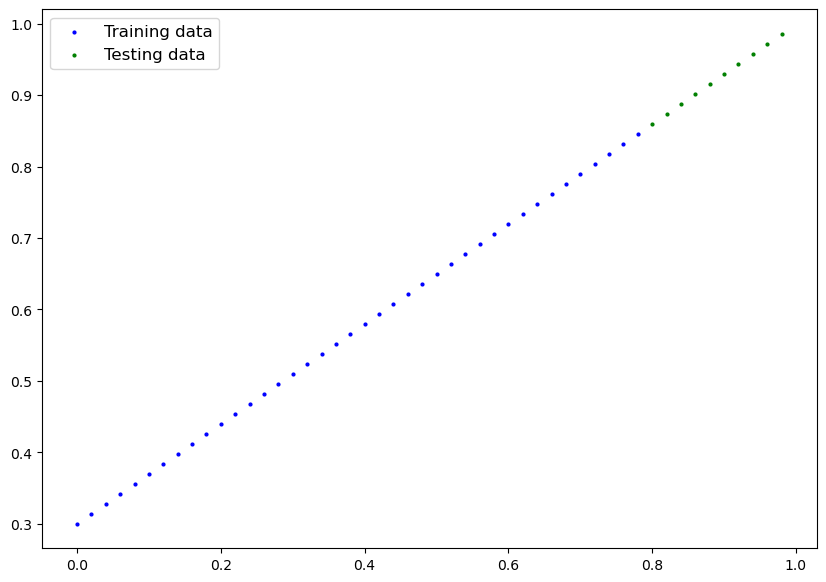

In [241]:
plot_predictions()

# 2. Build a neural network

Our first PyTorch Model!


What our model does:
- Start with random values
- Look At training data and adjoust the random values to better represent the ideal values

How does it do so? :
- Gradient Descent
- Backpropagation

In [242]:
# inherits from nn.Module
class LinearRegressionModel(nn.Module): # <- Almost everything in Pytorch inherits from this
  def __init__(self): # <-- Constructor
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, #<- randn random float 
                                            dtype=torch.float ))
    self.bias = nn.Parameter(torch.randn(1, requires_grad = True, dtype=torch.float))



  # forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- x is the input data
    return self.weights * x + self.bias  # linear regression formula



## Pytorch model building essentials



### Building Models
* torch.nn - contains all building blocks for nn
* torch.nn.Parameter - Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
* torch.nn.Module - The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
* def forward() - All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above)

### Optimize Gradient Descent
* torch.optim - Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).


### Dealing with large Data
* torch.utils.data.Dataset - Represetns a map between key and sample of your data. such as images and labels
* torch.utils.data.DataLoader - Creates a Python iterable over a torch dataset


[Cheat sheet](https://pytorch.org/tutorials/beginner/ptcheat.html)

<img src="../images/pytorch_universe.png" height="400px">


## Check the contents of our Pytorch model
What do we have inside our model 

In [243]:
# Create a random seed

torch.manual_seed(42)

# create an instance of the model (this is a subclass of nn.model)

model_0 = LinearRegressionModel()

# Check out params
list(model_0.parameters()) 

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [244]:
# List named Parameters
model_0.state_dict()

# Our goal is it to transform weights and bias to the original values at the top 0.7 and 0.3

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## making prediction using torch.inference_mode


In [245]:
# inference mode turns off gradient tracking (are finished with training now inference mode) -> Faster predictions
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [246]:
# preds should be close to y_test
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

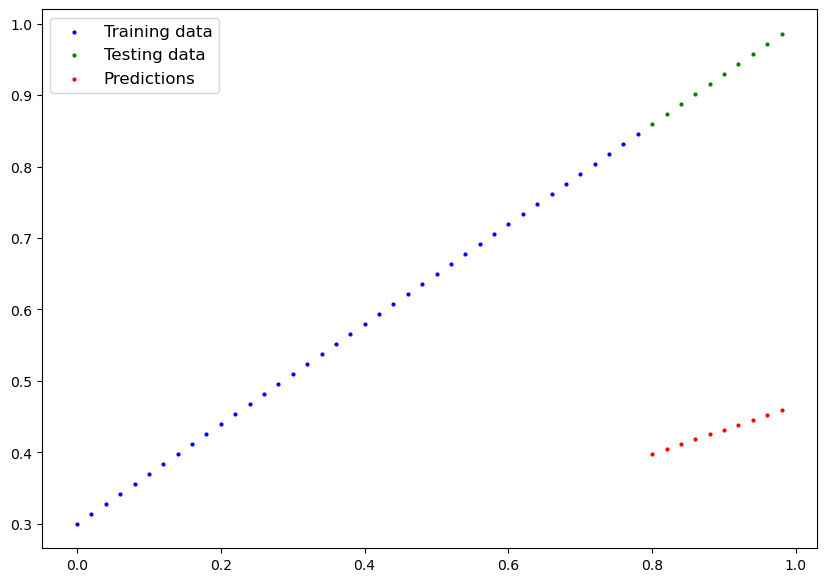

In [247]:
plot_predictions(predictions=y_preds)

## Setup an loss Function


In [248]:
# Setup a loss function
loss_fn = nn.L1Loss()

# create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # lr = learning rate


## Building a training loop in PyTorch

0. Loop Trough the data
1. forward pass (this involves data moving through our models ``forward`` function)
2. Calculate the loss (forward pass vs ground trouth)
3. Optimize zero grad
4. loss backwards (backpropagation) - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to loss
5. Optimizer step (gradient descent) - use the optimzer to improve the loss


In [249]:
# An epoch is one loop through the data

epochs = 200
torch.manual_seed(42)

# Track Different values
epoch_count = []
train_loss_values = []
test_loss_values = []
train_loss_values

# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in Pytorch sets all parameters that require gradients to require gradients
  
  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimze Zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward ()

  # 5. gradient descent
  optimizer.step() # by default how the optimizier changes will accumulate through the loop .. so have zero in step 3. for next loop
  
  # TESTING
  model_0.eval() # Turns off different settings in the model not needed for evaluation
  with torch.inference_mode():
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss.detach().numpy())
    test_loss_values.append(test_loss.detach().numpy())
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

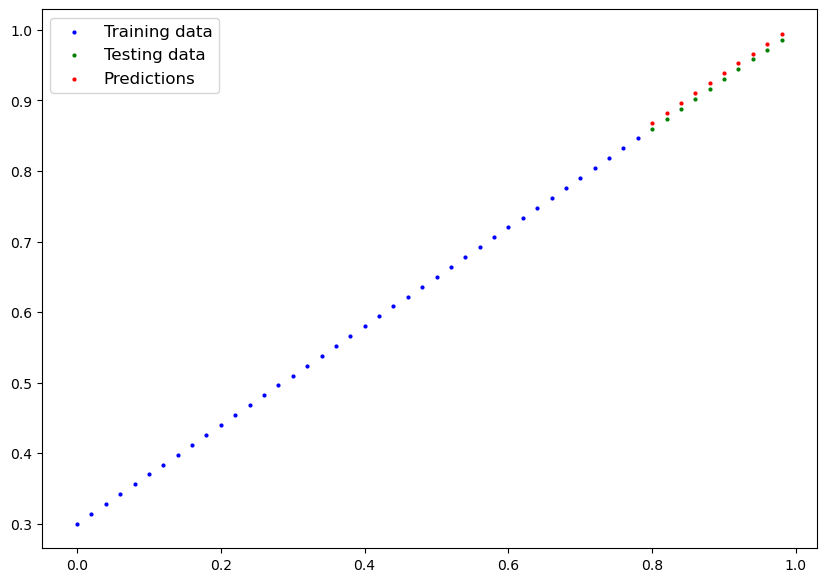

In [250]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

plot_predictions(predictions=y_preds_new)

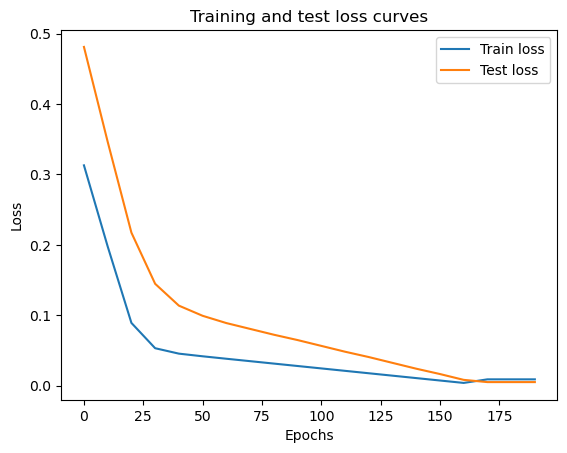

In [251]:
# Plot the loss curves

# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();


## Saving a model in Pytorch

There are three main methods you should know for saving and loading models in Pytorch

1. `torch.save()` - allows to save pytorch objects in pythons pickle format 
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a models saved state dictionary

In [253]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a model in Pytorch

In [256]:
# To load in a saved state_dict we have to instatiate a new instance of our model class

loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (update new instance)

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [258]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])